In [14]:
import pandas as pd
import numpy as np
import random

# 1. Load database asli (Pastikan file csv ada)
df_master = pd.read_csv('database_gizi_final.csv')

def filter_makanan_manusia_final(df):
    menu_umum = ['nasi', 'mie', 'ayam', 'ikan', 'telur', 'daging', 'sapi', 'tempe', 'tahu', 'sayur', 'sop', 'soto', 'pisang', 'pepaya', 'jeruk', 'roti', 'kentang', 'tuna', 'udang']
    
    # List "Haram" yang sudah lo update
    kata_haram = [
        'ampas', 'biji', 'kulit', 'darah', 'mentah', 'tepung', 'minyak', 'lemak', 
        'bubuk', 'buah merah', 'biang', 'ekstrak', 'asam', 'ragi', 'mentega', 
        'ginjal', 'ndusuk', 'nipis', 'ledre', 'kecimpring', 'putu', 'kepok',
        'penyu', 'maleo', 'hutan', 'kucing', 'anjing', 'hiu' # Proteksi tambahan
    ]
    
    pattern_menu = '|'.join(menu_umum)
    pattern_haram = '|'.join(kata_haram)
    
    # Filter tahap 1: Sesuai menu umum & bukan kata haram
    df_clean = df[df['Nama'].str.contains(pattern_menu, case=False, na=False)].copy()
    df_clean = df_clean[~df_clean['Nama'].str.contains(pattern_haram, case=False, na=False)]
    
    # Filter tahap 2: CEGAH IKAN MENTAH (Buang 'segar' jika ada 'ikan/daging/ayam')
    is_mentah = (df_clean['Nama'].str.contains('segar', case=False)) & \
                (df_clean['Nama'].str.contains('ikan|ayam|daging|sapi|telur', case=False))
    df_clean = df_clean[~is_mentah]
    
    return df_clean
    return df_clean
# Eksekusi filter
db_final = filter_makanan_manusia_final(df_master)
print(f"Berhasil menyaring! Tersisa {len(db_final)} menu layak konsumsi.")

Berhasil menyaring! Tersisa 174 menu layak konsumsi.


In [15]:
def setup_user_context_pro(berat, tinggi, usia, gender, goal, aktivitas_kerja):
    # 1. Hitung BMR (Mifflin-St Jeor)
    if gender.lower() == 'pria':
        bmr = (10 * berat) + (6.25 * tinggi) - (5 * usia) + 5
    else:
        bmr = (10 * berat) + (6.25 * tinggi) - (5 * usia) - 161
        
    # 2. PAL berdasarkan aktivitas kerja (Aktivitas non-olahraga/NEAT)
    pal_map = {
        'sedentary': 1.2, 'light': 1.375, 'moderate': 1.55, 
        'active': 1.725, 'extra_active': 1.9
    }
    pal = pal_map.get(aktivitas_kerja.lower(), 1.2)
    tdee = bmr * pal
    
    # Adjust berdasarkan Goal
    if goal.lower() == 'turun': tdee -= 500
    elif goal.lower() == 'naik': tdee += 500
    
    # Target Protein (1.2g per kg berat badan)
    target_protein = berat * 1.2
    
    return {'Energi': tdee, 'Protein': target_protein}

def apply_guardrails(porsi, kategori, nama_item):
    nama_low = nama_item.lower()
    if kategori == 'karbo':
        p_min, p_max = 50, 200
    elif kategori == 'protein':
        olahan = ['sosis', 'nugget', 'bakso', 'kornet', 'ham', 'abon', 'sarden']
        if any(x in nama_low for x in olahan):
            p_min, p_max = 30, 100
        else:
            p_min, p_max = 50, 150
    elif kategori == 'sayur':
        p_min, p_max = 100, 250
    elif kategori == 'buah':
        p_min, p_max = 50, 150
    else:
        p_min, p_max = 50, 150
    # Tambahkan ini di fungsi apply_guardrails di Cell 2
    if 'keripik' in nama_low or 'krupuk' in nama_low:
        p_min, p_max = 10, 30  # Keripik cuma boleh maksimal 30 gram (buat pelengkap doang)
    return max(p_min, min(p_max, porsi))

In [16]:
def buat_individu_bundle_pro(db, berat_user):
    # 1. Definisi Kata Kunci Kategori
    kat_keywords = {
        'karbo': 'nasi|mie|roti|kentang|sagu|singkong',
        'protein': 'ayam|ikan|daging|sapi|telur|tempe|tahu|sosis|nugget|udang',
        'sayur': 'bayam|kangkung|sop|wortel|sayur|cap cai|asam|bening',
        'buah': 'pisang|apel|jeruk|pepaya|semangka|buah'
    }

    # 2. Definisi Makanan Sampingan (Akan difilter dari Menu Utama)
    sampingan_keywords = 'kerupuk|keripik|krupuk|kripik|rempeyek|ledre|roti|snack|gorengan'

    # 3. Helper: Pengambil Sampel dengan Logika Tipe Makanan
    def get_safe_sample_pro(kat, tipe='utama'):
        subset = db[db['Nama'].str.contains(kat_keywords[kat], case=False, na=False)].copy()
        
        if tipe == 'utama':
            # Buang makanan ringan dari pilihan menu utama (Mencegah makan siang kerupuk)
            subset = subset[~subset['Nama'].str.contains(sampingan_keywords, case=False, na=False)]
        
        # Jika subset kosong (karena filter terlalu ketat), ambil apa saja dari kategori tersebut
        if subset.empty:
            subset = db[db['Nama'].str.contains(kat_keywords[kat], case=False, na=False)]
            
        return subset.sample(1).iloc[0] if not subset.empty else db.sample(1).iloc[0]

    menu = []
    # 4. Struktur Jadwal Makan Manusiawi
    # Format: (Waktu Makan, [ (Kategori, Tipe) ])
    jadwal = [
        ('SARAPAN', [('karbo', 'utama'), ('protein', 'utama')]),
        ('MAKAN SIANG', [('karbo', 'utama'), ('protein', 'utama'), ('sayur', 'utama')]),
        ('MAKAN MALAM', [('karbo', 'utama'), ('protein', 'utama'), ('sayur', 'utama')]),
        ('CAMILAN', [('buah', 'utama')])
    ]

    for waktu, kats in jadwal:
        for kat, tipe in kats:
            item = get_safe_sample_pro(kat, tipe)
            # Panggil guardrails porsi yang sudah kita buat di Cell 2
            porsi = apply_guardrails(random.randint(50, 200), kat, item['Nama'])
            
            menu.append({
                'nama': item['Nama'], 
                'porsi': porsi, 
                'meal': waktu, 
                'kategori': kat, 
                'energi': item['Energi'], 
                'protein': item['Protein']
            })
    return menu

def hitung_fitness_bundle(menu, target):
    total = {'Energi': 0, 'Protein': 0}
    list_nama = []
    
    for m in menu:
        f = m['porsi'] / 100
        total['Energi'] += m['energi'] * f
        total['Protein'] += m['protein'] * f
        list_nama.append(m['nama'])
    
    # --- PENALTY LAYER ---
    
    # 1. Pinalti Duplikat (Variasi menu harus beda tiap waktu makan)
  # --- UPDATE PENALTY LAYER ---
    
    # Ambil kata pertama (Bahan Utama) untuk cek variasi
    bahan_utama = [m['nama'].split()[0].lower() for m in menu]
    
    # 1. Pinalti Duplikat Bahan (Misal: Pagi Ayam, Siang Ayam)
    pinalti_duplikat = 0
    # Hitung berapa banyak bahan yang muncul lebih dari sekali
    jumlah_unik = len(set(bahan_utama))
    if jumlah_unik < len(bahan_utama):
        # Semakin banyak yang kembar, pinalti semakin berlipat
        pinalti_duplikat = (len(bahan_utama) - jumlah_unik) * 1500
        
    # 2. Pinalti Energi (Kalori harus presisi)
    diff_e = abs(total['Energi'] - target['Energi'])
    if total['Energi'] > target['Energi']: 
        diff_e *= 50 # Pinalti lebih berat jika kelebihan kalori (mencegah kegemukan)
        
    # 3. Pinalti Protein (Protein boleh surplus sedikit, tapi jangan kurang)
    diff_p = total['Protein'] - target['Protein']
    pinalti_p = 0
    if diff_p < 0: # Jika protein kurang dari target
        pinalti_p = abs(diff_p) * 100
    else: # Jika protein lebih, pinalti ringan saja (Surplus protein aman untuk otot)
        pinalti_p = abs(diff_p) * 5 

    # Skor Akhir (Semakin kecil error, semakin besar Fitness)
    error = diff_e + pinalti_p + pinalti_duplikat
    return 1 / (1 + error), total

=== FORM INPUT PENGGUNA PRO V2 ===


Berat (kg):  55
Tinggi (cm):  160
Usia:  25
Gender (pria/wanita):  wanita
Goal (naik/turun/tetap):  tetap
Langkah Harian:  4500
Durasi Olahraga (Jam):  0



Level Aktivitas Kerja:
1. sedentary (Kantoran/Duduk)
2. light (Guru/Nakes/Banyak Jalan)
3. moderate (Kurir/Pelayan/Lapangan Ringan)
4. active (Kuli/Petani/Atlet)
5. extra_active (Tambang/Konstruksi Berat)


Pilih level (tulis namanya, misal: light):  sedentary
Alergi (pisahkan koma):  



TARGET: 1746.19 kkal | HASIL: 1745.68 kkal
TARGET PROTEIN: 82.5g | HASIL: 82.63g
[SARAPAN] Mie Sagu | 159 gram
[SARAPAN] Ayam, ampela, goreng | 66 gram
[MAKAN SIANG] Nasi beras merah | 74 gram
[MAKAN SIANG] Sapi, abon, asli | 80 gram
[MAKAN SIANG] Anyang, sayur | 100 gram
[MAKAN MALAM] Kentang, segar | 184 gram
[MAKAN MALAM] Bebek, daging, goreng | 150 gram
[MAKAN MALAM] Bayam, rebus | 168 gram
[CAMILAN] Pisang kayu, segar | 140 gram


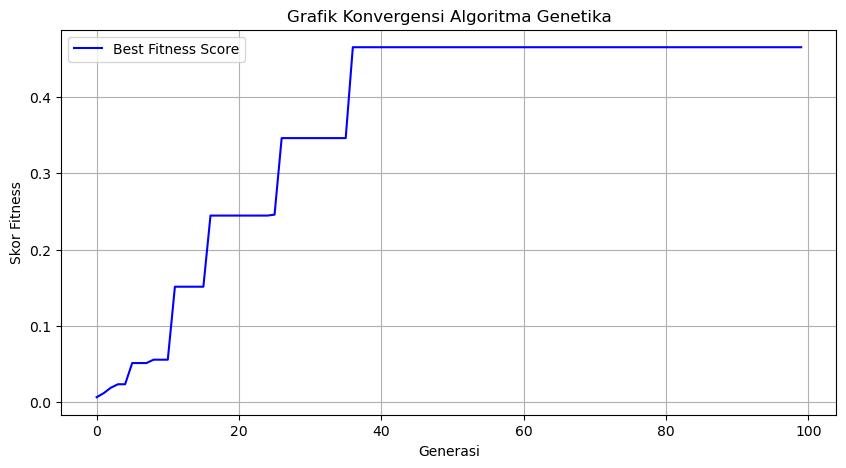

In [19]:
# --- 1. INPUT USER DETAIL ---
print("=== FORM INPUT PENGGUNA PRO V2 ===")
berat_u = float(input("Berat (kg): "))
tinggi_u = float(input("Tinggi (cm): "))
usia_u = int(input("Usia: "))
gender_u = input("Gender (pria/wanita): ")
goal_u = input("Goal (naik/turun/tetap): ")

langkah_u = int(input("Langkah Harian: "))
gym_u = float(input("Durasi Olahraga (Jam): "))
print("\nLevel Aktivitas Kerja:")
print("1. sedentary (Kantoran/Duduk)")
print("2. light (Guru/Nakes/Banyak Jalan)")
print("3. moderate (Kurir/Pelayan/Lapangan Ringan)")
print("4. active (Kuli/Petani/Atlet)")
print("5. extra_active (Tambang/Konstruksi Berat)")
pekerjaan_u = input("Pilih level (tulis namanya, misal: light): ").lower()
alergi_u = input("Alergi (pisahkan koma): ")
alergi_l = [x.strip() for x in alergi_u.split(',')] if alergi_u else []

# --- 2. SETUP KONTEKS FINAL DENGAN LOGIKA PROTEIN DINAMIS ---
def setup_final_v2(berat, tinggi_cm, usia, gender, goal, langkah, durasi_gym, pekerjaan):
    tinggi_m = tinggi_cm / 100
    if gender.lower() == 'pria':
        rmr = (9.65 * berat) + (573 * tinggi_m) - (5.08 * usia) + 260
    else:
        rmr = (7.38 * berat) + (607 * tinggi_m) - (2.31 * usia) + 43
    
    pal_map = {'sedentary': 1.2, 'light': 1.375, 'moderate': 1.55, 'active': 1.725, 'extra_active': 1.9}
    pal_val = pal_map.get(pekerjaan, 1.2)

    # TDEE Calculation
    tdee = (rmr * pal_val) + ((langkah/1000) * (berat * 0.45)) + (6.0 * berat * durasi_gym)
    if 'naik' in goal.lower(): tdee += 500
    elif 'turun' in goal.lower(): tdee -= 500
    
    # --- LOGIKA PROTEIN OTOMATIS (Sains Nutrisi) ---
    # Jika turun berat: Protein tinggi (2.0) untuk cegah otot hilang
    # Jika naik berat: Protein tinggi (1.8) untuk bangun otot
    # Jika tetap: Protein moderat (1.5)
    if 'turun' in goal.lower():
        rasio_p = 2.0
    elif 'naik' in goal.lower():
        rasio_p = 1.8
    else:
        rasio_p = 1.5
    if berat < 55 and 'naik' in goal.lower():
        rasio_p = 2.0
        
    return {'Energi': round(tdee, 2), 'Protein': round(berat * rasio_p, 2)}

target_user = setup_final_v2(berat_u, tinggi_u, usia_u, gender_u, goal_u, langkah_u, gym_u, pekerjaan_u)

# --- 3. FILTER DATABASE & EVOLUSI ---
db_pencarian = db_final.copy()
for bahan in alergi_l:
    db_pencarian = db_pencarian[~db_pencarian['Nama'].str.contains(bahan, case=False, na=False)]

# Inisialisasi Populasi
pop_size = 150
populasi = [buat_individu_bundle_pro(db_pencarian, berat_u) for _ in range(pop_size)]

history_fitness = []

for gen in range(100):
    skor_fit_list = [hitung_fitness_bundle(ind, target_user) for ind in populasi]
    pop_sorted = [ind for _, ind in sorted(zip(skor_fit_list, populasi), key=lambda x: x[0][0], reverse=True)]

    best_fitness_current = max([skor[0] for skor in skor_fit_list])
    history_fitness.append(best_fitness_current)
    
    pemenang = pop_sorted[0]
    baru = [pemenang] 
    
    while len(baru) < pop_size:
        p1, p2 = random.sample(pop_sorted[:50], 2)
        titik = random.randint(1, len(pemenang)-1)
        anak = [item.copy() for item in (p1[:titik] + p2[titik:])]
        
        if random.random() < 0.3:
            idx = random.randint(0, len(anak)-1)
            anak[idx]['porsi'] += random.randint(-15, 15)
            anak[idx]['porsi'] = apply_guardrails(anak[idx]['porsi'], anak[idx]['kategori'], anak[idx]['nama'])
        baru.append(anak)
    populasi = baru

# --- 4. OUTPUT ---
final_fit, final_gizi = hitung_fitness_bundle(pemenang, target_user)
print("\n" + "="*50)
print(f"TARGET: {target_user['Energi']} kkal | HASIL: {round(final_gizi['Energi'], 2)} kkal")
print(f"TARGET PROTEIN: {target_user['Protein']}g | HASIL: {round(final_gizi['Protein'], 2)}g")
print("="*50)
for m in pemenang:
    print(f"[{m['meal']}] {m['nama']} | {round(m['porsi'], 1)} gram")

    import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_fitness, label='Best Fitness Score', color='blue')
plt.title('Grafik Konvergensi Algoritma Genetika')
plt.xlabel('Generasi')
plt.ylabel('Skor Fitness')
plt.grid(True)
plt.legend()
plt.show()